In [1]:
import sys, os, glob, logging, warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sw_plotting import plotCurvatureBar, plotCurvatureHeatmap, plotCurvatureSwarm, plot_curvature, plot_curvature_one_line
from sw_utilities import tukeyTest, getCurvatureDfList, getHighCurvatureCounts
# from scipy.interpolate import UnivariateSpline, interp1d
# from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
# from statsmodels.stats.libqsturng import psturng
# import scipy.stats as stats

# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

# ignore warnings
warnings.filterwarnings('ignore')

# plotting configuration
# %matplotlib inline
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# Make a folder if it is not already there to store exported figures
!mkdir ../jupyter_figures


mkdir: ../jupyter_figures: File exists


In [4]:
# combining 2 data sets for plotting curvature of the initial phenotype description

# read in the 1st data set
inputFolder1 = "../data/spheroids-curvature-data/190926-DLD-1-spheroids-6dpt-ROI-output/"

# This set of files contains 6, 5, 11, 33 and 11 samples for groups 1-4 and 6:
# Group 1: sg-Control only, DMSO, MG
# Group 2: sg-Control only, ABA, MG
# Group 3: sg-Control mixed with sg1-Ecad (4:1), DMSO, MG
# Group 4: sg-Control mixed with sg1-Ecad (4:1), ABA, MG
# Group 6: sg-Control mixed with sg2-Ecad (4:1), ABA, MG
groups1 = ["1"]*6 + ["2"]*5 + ["3"]*11 + ["4"]*33 + ["6"]*11

# read in the 2nd data set
inputFolder2 = "../data/spheroids-curvature-data/191008-DLD-1-spheroids-6-dpt-single-z-with-fluorescence-ignore-bleb-NikonSS-ROI-output/"

# This set of files contains 5, 5, 5, 10 samples for groups 1-4:
# Group 1: sg-Control only, DMSO, MG
# Group 2: sg-Control only, ABA, MG
# Group 3: sg-Control mixed with sg1-Ecad (4:1), DMSO, MG
# Group 4: sg-Control mixed with sg1-Ecad (4:1), ABA, MG
# Group 5: sg-Control mixed with sg2-Ecad (4:1), DMSO, MG
# Group 6: sg-Control mixed with sg2-Ecad (4:1), ABA, MG
groups2 = ["1"]*5 + ["2"]*5 + ["3"]*5 + ["4"]*10 + ["5"]*5 + ["6"]*10

# Read in the data sets
curvatureDfList1 = getCurvatureDfList(inputFolder1, 500)
curvatureDfList2 = getCurvatureDfList(inputFolder2, 500)


2020-04-16 09:25:07,763 - INFO - NumExpr defaulting to 8 threads.


In [5]:
# combine first 55 data points of the first data set,
# and the first 25 of the second data set
curvatureDfList = curvatureDfList2[:25] + curvatureDfList1[:55]
groups = groups2[:25] + groups1[:55]
outputPrefix = "190926-191008-6dpt-combined"

# Get the curvature array in the original order
curvatureArray = [np.array(df.curvature) for df in curvatureDfList]
# Get the counting list of high-curvature points in original order
## For using fixed curvature threshold
# curvatureThreshold = 0.02
## For using context-dependent curvature threshold determined by the 90th percentile
## of the list of the 90th percentile of each curvature set
curvatureThreshold = np.percentile(np.percentile(curvatureArray, 90, axis=1), 90)

counts = getHighCurvatureCounts(curvatureArray, curvatureThreshold)

# sort the combined data frame list based their experimental group
idx = np.arange(len(groups))
idxSorted = [x for _,x in sorted(zip(groups,idx))]
curvatureDfSorted = [curvatureDfList[i] for i in idxSorted]

# Shuffle the order of data points within each experimental group
# to evenly mix the two sets of experiments

# groups 1, 2, 3, 4 has sample numbers: 11, 10, 16, 43
idx = np.arange(len(groups))
idxGroup1, idxGroup2, idxGroup3, idxGroup4 = idx[:11], idx[11:21], idx[21:37], idx[37:80]
idx1Shuffled, idx2Shuffled, idx3Shuffled, idx4Shuffled = idxGroup1, idxGroup2, idxGroup3, idxGroup4

randomSeed = 29
random.seed(randomSeed)# use this to control the random generator to make the figure reproducile
random.shuffle(idx1Shuffled), random.shuffle(idx2Shuffled), random.shuffle(idx3Shuffled), random.shuffle(idx4Shuffled)
# print(idx1Shuffled, idx2Shuffled, idx3Shuffled, idx4Shuffled)
idxShuffled = np.concatenate([idx1Shuffled, idx2Shuffled, idx3Shuffled, idx4Shuffled])
# print(idxShuffled)
curvatureDfShuffled = [curvatureDfSorted[i] for i in idxShuffled]

# Get in-group shuffled curvature array for heatmap plotting
curvatureArrayShuffled = [np.array(df.curvature) for df in curvatureDfShuffled]

# Get stats of between-group comparisons
tukeyTest(counts, groups)


Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     1      2  -0.4836   0.9 -6.8707  5.9034  False
     1      3   0.7864   0.9 -4.9391  6.5118  False
     1      4  10.9805 0.001  6.0414 15.9197   True
     2      3     1.27   0.9 -4.6227  7.1627  False
     2      4  11.4642 0.001  6.3322 16.5962   True
     3      4  10.1942 0.001  5.9135 14.4749   True
---------------------------------------------------
p values of all pair-wise tests:
 [0.9   0.9   0.001 0.9   0.001 0.001]


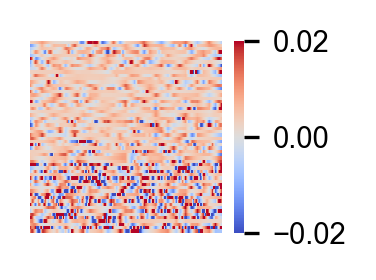

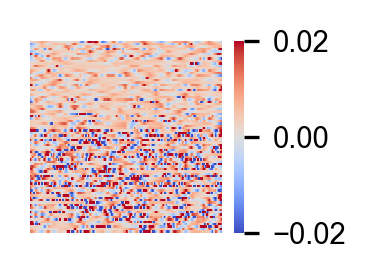

In [6]:
# plot heatmap of curvature of first 58 data points to make group 4 not super over-represented
# sample size of groups 1-4: 11, 10, 16, 20
outputFigPath = "../jupyter_figures/" + outputPrefix + "-4groups-curvature-heatmap-subset.svg"
plotCurvatureHeatmap(curvatureArrayShuffled[:58], outputFigPath)

# plot heatmap of all data points
outputFigPath = "../jupyter_figures/" + outputPrefix + "-4groups-curvature-heatmap-all.svg"
plotCurvatureHeatmap(curvatureArrayShuffled, outputFigPath)


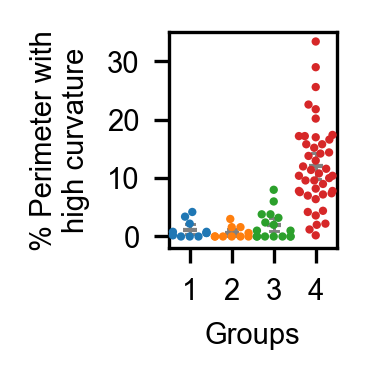

In [7]:
outputFigPath = "../jupyter_figures/" + outputPrefix + "-4groups-curvature-swarm.svg"
plotCurvatureSwarm(groups, counts, outputFigPath)


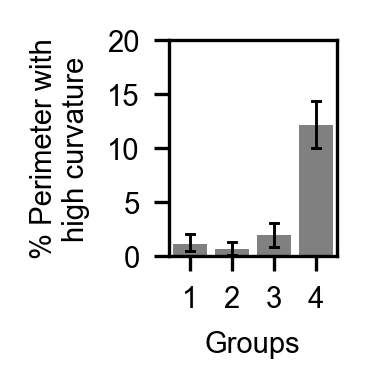

In [8]:
outputFigPath = "../jupyter_figures/" + outputPrefix + "-4groups-curvature-bar.svg"
plotCurvatureBar(groups, counts, outputFigPath, yMax=20, yTicks=[0,5,10,15,20])


In [9]:
df = pd.DataFrame({'groups': groups, 'data_to_compare': counts})
df.to_csv('../data_cleaned/' + outputPrefix + '-4groups-percent-high-curvature.csv')


In [10]:
# combine all 6 groups of data points
curvatureDfList = curvatureDfList2 + curvatureDfList1
groups = groups2 + groups1
outputPrefix = "190926-191008-6dpt-combined-all-6-groups"

# Get the curvature array in the original order
curvatureArray = [np.array(df.curvature) for df in curvatureDfList]
# Get the counting list of high-curvature points in original order
# curvatureThreshold = 0.02
# curvatureThreshold = np.percentile(curvatureArray, 90)
curvatureThreshold = np.percentile(np.percentile(curvatureArray, 90, axis=1), 90)

counts = getHighCurvatureCounts(curvatureArray, curvatureThreshold)

# sort the combined data frame list based their experimental group
idx = np.arange(len(groups))
idxSorted = [x for _,x in sorted(zip(groups,idx))]
curvatureDfSorted = [curvatureDfList[i] for i in idxSorted]

# Shuffle the order of data points within each experimental group
# to evenly mix the two sets of experiments

# groups 1, 2, 3, 4, 5, 6 has sample numbers: 11, 10, 16, 43, 5, 21
idx = np.arange(len(groups))
idxGroup1, idxGroup2, idxGroup3, idxGroup4, idxGroup5, idxGroup6 = idx[:11], idx[11:21], idx[21:37], idx[37:80], idx[80:85], idx[85:106]
idx1Shuffled, idx2Shuffled, idx3Shuffled, idx4Shuffled, idx5Shuffled, idx6Shuffled = idxGroup1, idxGroup2, idxGroup3, idxGroup4, idxGroup5, idxGroup6

randomSeed = 29
random.seed(randomSeed)# use this to control the random generator to make the figure reproducile
random.shuffle(idx1Shuffled), random.shuffle(idx2Shuffled), random.shuffle(idx3Shuffled), random.shuffle(idx4Shuffled), random.shuffle(idx5Shuffled), random.shuffle(idx6Shuffled)
# print(idx1Shuffled, idx2Shuffled, idx3Shuffled, idx4Shuffled)
idxShuffled = np.concatenate([idx1Shuffled, idx2Shuffled, idx3Shuffled, idx4Shuffled, idx5Shuffled, idx6Shuffled])
# print(idxShuffled)
curvatureDfShuffled = [curvatureDfSorted[i] for i in idxShuffled]

# Get in-group shuffled curvature array for heatmap plotting
curvatureArrayShuffled = [np.array(df.curvature) for df in curvatureDfShuffled]

# Get stats of between-group comparisons
tukeyTest(counts, groups)


Summary of test:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2  -0.4745    0.9  -7.5194  6.5703  False
     1      3    0.733    0.9  -5.5822  7.0481  False
     1      4  10.4059  0.001    4.958 15.8538   True
     1      5   4.2655 0.6867  -4.4309 12.9619  False
     1      6  10.5931  0.001    4.592 16.5942   True
     2      3   1.2075    0.9  -5.2921  7.7071  False
     2      4  10.8805  0.001   5.2198 16.5411   True
     2      5     4.74 0.6101  -4.0912 13.5712  False
     2      6  11.0676  0.001   4.8728 17.2625   True
     3      4    9.673  0.001   4.9513 14.3946   True
     3      5   3.5325 0.7907  -4.7284 11.7934  False
     3      6   9.8601  0.001   4.5096 15.2106   True
     4      5  -6.1405 0.1872 -13.7588  1.4779  False
     4      6   0.1872    0.9  -4.1053  4.4796  False
     5      6   6.3276 0.2072  -1.6957 14.3509  False
----------

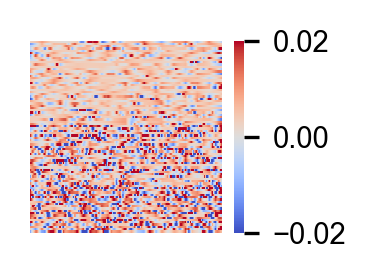

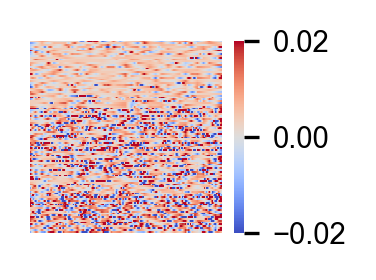

In [11]:
# plot heatmap of curvature of first 58 data points to make group 4 not super over-represented
# sample size of groups 1-4: 11, 10, 16, 21
outputFigPath = "../jupyter_figures/" + outputPrefix + "-curvature-heatmap-subset.svg"
plotCurvatureHeatmap(np.concatenate([curvatureArrayShuffled[:58], curvatureArrayShuffled[80:106]]), outputFigPath)

# plot heatmap of all data points
outputFigPath = "../jupyter_figures/" + outputPrefix + "-curvature-heatmap-all.svg"
plotCurvatureHeatmap(curvatureArrayShuffled, outputFigPath)


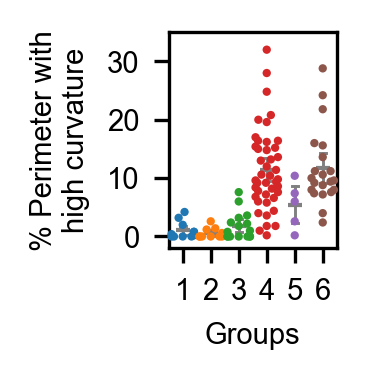

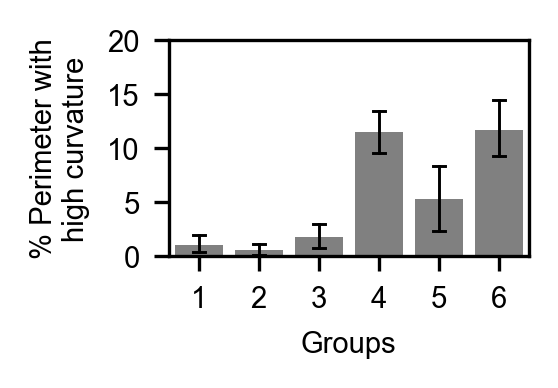

In [12]:
outputFigPath = "../jupyter_figures/" + outputPrefix + "-curvature-swarm.svg"
plotCurvatureSwarm(groups, counts, outputFigPath)

outputFigPath = "../jupyter_figures/" + outputPrefix + "-curvature-bar.svg"
plotCurvatureBar(groups, counts, outputFigPath, yMax=20, yTicks=[0,5,10,15,20], fig_width=1.5, fig_height=0.9)


In [13]:
df = pd.DataFrame({'groups': groups, 'data_to_compare': counts})
df.to_csv('../data_cleaned/' + outputPrefix + '-percent-high-curvature.csv')


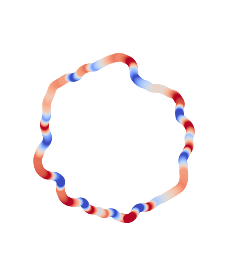

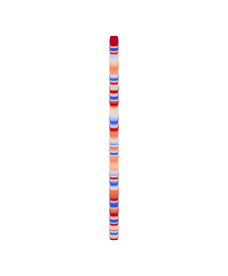

In [14]:
# Plot out boundary color coded by curvature values for showcase in supplemental figure
i = 36
outputFigPath = "../jupyter_figures/" + outputPrefix + str(i) + "-curvature-color-coded-boundary.svg"
plot_curvature(curvatureDfList[i], outputFigPath, size=1)
outputFigPath = "../jupyter_figures/" + outputPrefix + str(i) + "-curvature-color-coded-one-line.svg"
plot_curvature_one_line(curvatureDfList[i], outputFigPath, size=1)


In [15]:
# Integrin co-repression data set 1

# Specfiy the data set
inputFolder = "../data/spheroids-curvature-data/20191219-6dpt-singleZ-D193-D267-D301-D2-integrin-co-modulation-ROI-output/"
outputPrefix = "191219-6dpt-D193-D267-D301-D2-integrin-co-repression"

# Annotate the data set
#
# The layout of this data set is straightforward.
# For integrin co-repression, all spheroids were treated with Matrigel and ABA
#
# Group 1, B2-B11: sg-control mixed with sg1-Ecad (1:1)
# Group 2, C2-C11: sg-Itgb1 mixed with sg1-Ecad (1:1)
# Group 3, D2-E11: sg-control mixed with sg1-Ecad/sg-Itgb1 (1:1)
# Group 4, F2-G11: sg-Itgb1 mixed with sg1-Ecad/sg-Itgb1 (1:1)
groups = ["1"]*10 + ["2"]*10 + ["3"]*20 + ["4"]*20

# Read in the data set
curvatureDfList = getCurvatureDfList(inputFolder, 500)
# Get the curvature array
curvatureArray = [np.array(df.curvature) for df in curvatureDfList]
# Get the counting list of high-curvature points
# curvatureThreshold = 0.02
curvatureThreshold = np.percentile(np.percentile(curvatureArray, 90, axis=1), 90)
print('curvatureThreshold: ', curvatureThreshold)
counts = getHighCurvatureCounts(curvatureArray, curvatureThreshold)

# Get stats of between-group comparisons
tukeyTest(counts, groups)


curvatureThreshold:  0.016655664927238516
Summary of test:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     1      2   -10.72  0.001 -15.3146  -6.1254   True
     1      3   -18.08  0.001 -22.0591 -14.1009   True
     1      4   -19.16  0.001 -23.1391 -15.1809   True
     2      3    -7.36  0.001 -11.3391  -3.3809   True
     2      4    -8.44  0.001 -12.4191  -4.4609   True
     3      4    -1.08 0.7922  -4.3289   2.1689  False
------------------------------------------------------
p values of all pair-wise tests:
 [0.001      0.001      0.001      0.001      0.001      0.79216603]


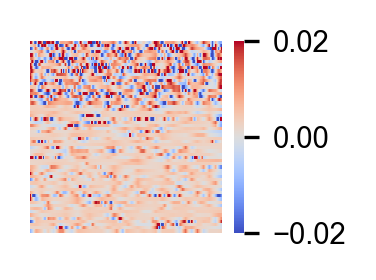

In [16]:
outputFigPath = "../jupyter_figures/" + outputPrefix + "-curvature-heatmap.svg"
plotCurvatureHeatmap(curvatureArray, outputFigPath)


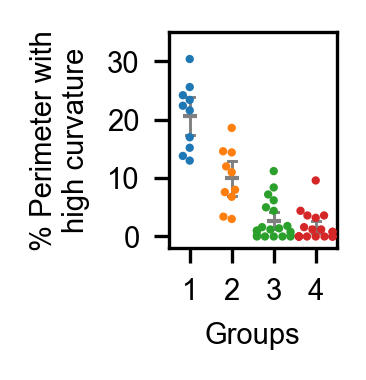

In [17]:
outputFigPath = "../jupyter_figures/" + outputPrefix + "-curvature-swarm.svg"
plotCurvatureSwarm(groups, counts, outputFigPath)


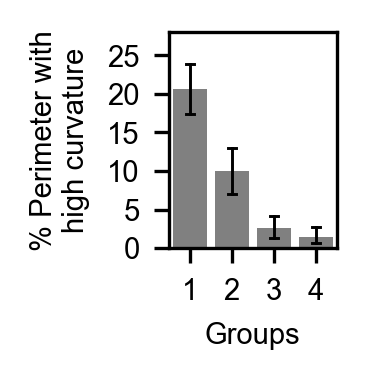

In [18]:
outputFigPath = "../jupyter_figures/" + outputPrefix + "-curvature-bar.svg"
plotCurvatureBar(groups, counts, outputFigPath, yMax=28, yTicks=[0,5,10,15,20,25])


In [19]:
df = pd.DataFrame({'groups': groups, 'data_to_compare': counts})
df.to_csv('../data_cleaned/' + outputPrefix + '-percent-high-curvature.csv')


In [20]:
# Integrin co-repression data set 2

# Specfiy the data set
inputFolder = "../data/spheroids-curvature-data/20191224-6dpt-singleZ-D193-D267-D301-D2-integrin-co-modulation-repeat-ROI-output/"
outputPrefix = "191224-6dpt-D193-D267-D301-D2-integrin-co-repression-repeat"

# Annotate the data set
#
# The layout of this data set is straightforward.
# For integrin co-repression, all spheroids were treated with Matrigel and ABA
#
# Group 1, B2-B11: sg-control mixed with sg1-Ecad (1:1)
# Group 2, C2-D11: sg-Itgb1 mixed with sg1-Ecad (1:1)
# Group 3, E2-F11: sg-control mixed with sg1-Ecad/sg-Itgb1 (1:1)
# Group 4, G2-G11: sg-Itgb1 mixed with sg1-Ecad/sg-Itgb1 (1:1)
# ***Note: B4, D2, D6, D7, D9 and D10 were off-center or off-focus, so removed for segmentation***
groups = ["1"]*9 + ["2"]*15 + ["3"]*20 + ["4"]*10

# Read in the data set
curvatureDfList = getCurvatureDfList(inputFolder, 500)
# Get the curvature array
curvatureArray = [np.array(df.curvature) for df in curvatureDfList]
# Get the counting list of high-curvature points
# curvatureThreshold = 0.02
# curvatureThreshold = np.percentile(curvatureArray, 90)
curvatureThreshold = np.percentile(np.percentile(curvatureArray, 90, axis=1), 90)
print('curvatureThreshold: ', curvatureThreshold)
counts = getHighCurvatureCounts(curvatureArray, curvatureThreshold)

# Get stats of between-group comparisons
tukeyTest(counts, groups)


curvatureThreshold:  0.017594971692480865
Summary of test:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
     1      2 -11.1067 0.001 -16.3062  -5.9072   True
     1      3 -18.1833 0.001 -23.1331 -13.2335   True
     1      4 -19.0933 0.001 -24.7594 -13.4273   True
     2      3  -7.0767 0.001 -11.2888  -2.8646   True
     2      4  -7.9867 0.001 -13.0211  -2.9523   True
     3      4    -0.91   0.9  -5.6861   3.8661  False
-----------------------------------------------------
p values of all pair-wise tests:
 [0.001 0.001 0.001 0.001 0.001 0.9  ]


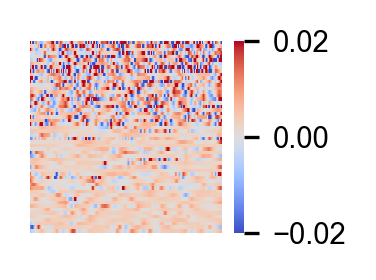

In [21]:
outputFigPath = "../jupyter_figures/" + outputPrefix + "-curvature-heatmap.svg"
plotCurvatureHeatmap(curvatureArray, outputFigPath)


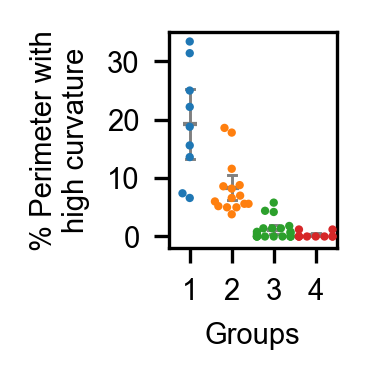

In [22]:
outputFigPath = "../jupyter_figures/" + outputPrefix + "-curvature-swarm.svg"
plotCurvatureSwarm(groups, counts, outputFigPath)


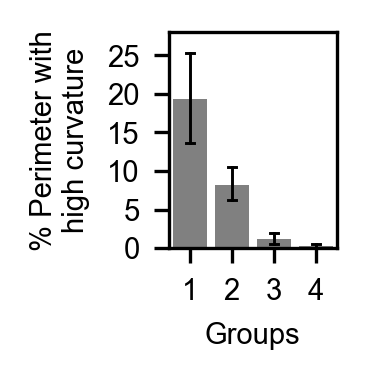

In [23]:
outputFigPath = "../jupyter_figures/" + outputPrefix + "-curvature-bar.svg"
plotCurvatureBar(groups, counts, outputFigPath, yMax=28, yTicks=[0,5,10,15,20,25])


In [24]:
df = pd.DataFrame({'groups': groups, 'data_to_compare': counts})
df.to_csv('../data_cleaned/' + outputPrefix + '-percent-high-curvature.csv')


In [25]:
# Integrin co-repression data set 3 (set 2 for 1 more day)

# Specfiy the data set
inputFolder = "../data/spheroids-curvature-data/20191225-7dpt-singleZ-D193-D267-D301-D2-integrin-co-modulation-repeat-ROI-output/"
outputPrefix = "191225-7dpt-D193-D267-D301-D2-integrin-co-repression-repeat"

# Annotate the data set
#
# The layout of this data set is straightforward.
# For integrin co-repression, all spheroids were treated with Matrigel and ABA
#
# Group 1, B2-B11: sg-control mixed with sg1-Ecad (1:1)
# Group 2, C2-D11: sg-Itgb1 mixed with sg1-Ecad (1:1)
# Group 3, E2-F11: sg-control mixed with sg1-Ecad/sg-Itgb1 (1:1)
# Group 4, G2-G11: sg-Itgb1 mixed with sg1-Ecad/sg-Itgb1 (1:1)
# Note: B4, D2, D6, D7, D9 and D10 were off-center or off-focus, so removed for segmentation
groups = ["1"]*9 + ["2"]*15 + ["3"]*20 + ["4"]*10

# Read in the data set
curvatureDfList = getCurvatureDfList(inputFolder, 500)
# Get the curvature array
curvatureArray = [np.array(df.curvature) for df in curvatureDfList]
# Get the counting list of high-curvature points
# curvatureThreshold = 0.02
# curvatureThreshold = np.percentile(curvatureArray, 90)
curvatureThreshold = np.percentile(np.percentile(curvatureArray, 90, axis=1), 90)
print('curvatureThreshold: ', curvatureThreshold)
counts = getHighCurvatureCounts(curvatureArray, curvatureThreshold)

# Get stats of between-group comparisons
tukeyTest(counts, groups)


curvatureThreshold:  0.019294809902949264
Summary of test:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     1      2  -5.5467 0.0175 -10.3465  -0.7468   True
     1      3 -12.5867  0.001  -17.156  -8.0174   True
     1      4 -15.9667  0.001 -21.1972 -10.7362   True
     2      3    -7.04  0.001 -10.9283  -3.1517   True
     2      4   -10.42  0.001 -15.0674  -5.7726   True
     3      4    -3.38 0.1882  -7.7889   1.0289  False
------------------------------------------------------
p values of all pair-wise tests:
 [0.01754421 0.001      0.001      0.001      0.001      0.18820461]


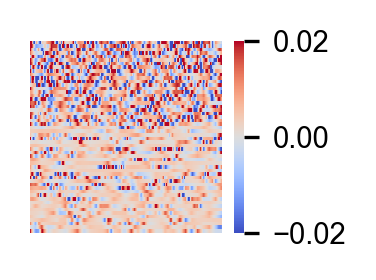

In [26]:
outputFigPath = "../jupyter_figures/" + outputPrefix + "-curvature-heatmap.svg"
plotCurvatureHeatmap(curvatureArray, outputFigPath)


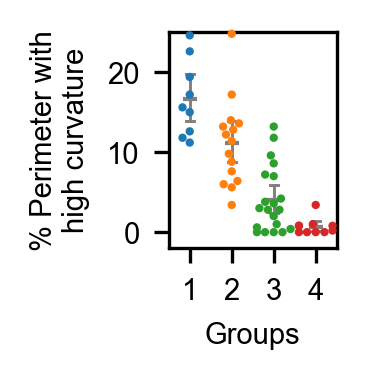

In [27]:
outputFigPath = "../jupyter_figures/" + outputPrefix + "-curvature-swarm.svg"
plotCurvatureSwarm(groups, counts, outputFigPath)


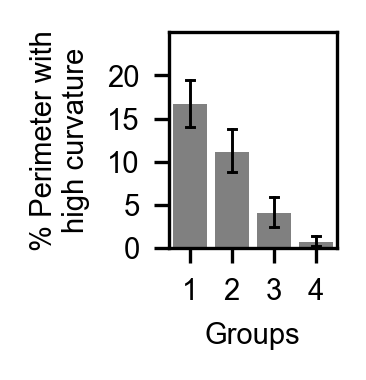

In [28]:
outputFigPath = "../jupyter_figures/" + outputPrefix + "-curvature-bar.svg"
plotCurvatureBar(groups, counts, outputFigPath, yMax=25, yTicks=[0,5,10,15,20])


In [29]:
df = pd.DataFrame({'groups': groups, 'data_to_compare': counts})
df.to_csv('../data_cleaned/' + outputPrefix + '-percent-high-curvature.csv')


In [30]:
# Integrin activation data set 1

# specify the data set
inputFolder = "../data/spheroids-curvature-data/20191219-6dpt-singleZ-integrin-activation-ROI-output/"
outputPrefix = "191219-6dpt-integrin-activation"
curvatureDfList = getCurvatureDfList(inputFolder, 500)

# Annotate the data set
#
# The layout of this data set is straightforward.
# For integrin activation test, only Matrigel was added (no ABA)
# Integrin activation was done by adding 50 uM MnCl2, 10 ug/mL TS2/16 or both
#
# Group 1, B2-B11: sg-Control only
# Group 2, C2-C6: sg-Control only, 50 uM MnCl2
# Group 3, C7-C11: sg-Control only, 10 ug/mL TS2/16
# Group 4, D2-D11: sg-Control only, 50 uM MnCl2 and 10 ug/mL TS2/16
# Group 5, E2-E11: sg-Control mixed with sg2-Ecad (4:1)
# Group 6, F2-F6: sg-Control mixed with sg2-Ecad (4:1), 50 uM MnCl2
# Group 7, F7-F11: sg-Control mixed with sg2-Ecad (4:1), 10 ug/mL TS2/16
# Group 8, G2-G11: sg-Control mixed with sg2-Ecad (4:1), 50 uM MnCl2 and 10 ug/mL TS2/16

groups = ["1"]*10 + ["2"]*5 + ["3"]*5 + ["4"]*10 +\
            ["5"]*10 + ["6"]*5 + ["7"]*5 + ["8"]*10

groups = ["1"]*10 + ["2"]*5 + ["1"]*5 + ["2"]*10 +\
            ["5"]*10 + ["6"]*5 + ["5"]*5 + ["6"]*10

# Read in the data set
curvatureDfList = getCurvatureDfList(inputFolder, 500)
# Get the curvature array
curvatureArray = [np.array(df.curvature) for df in curvatureDfList]
# Get the counting list of high-curvature points
# curvatureThreshold = np.percentile(np.percentile(curvatureArray[:30], 90, axis=1), 90)
curvatureThreshold = np.percentile(np.percentile(curvatureArray[30:], 90, axis=1), 90)
print('curvatureThreshold: ', curvatureThreshold)
counts = getHighCurvatureCounts(curvatureArray, curvatureThreshold)

# Get stats of between-group comparisons
tukeyTest(counts, groups)
tukeyTest(counts[:30],groups[:30])

from scipy.stats import ttest_ind
res1 = ttest_ind(np.concatenate([counts[0:10], counts[15:20]]), np.concatenate([counts[10:15], counts[20:30]]))
print(res1)
res2 = ttest_ind(np.concatenate([counts[30:40], counts[45:50]]), np.concatenate([counts[40:45], counts[50:60]]))
print(res2)


curvatureThreshold:  0.023570484777368644
Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   0.8667    0.9 -3.8447   5.578  False
     1      5   7.0667 0.0012  2.3553  11.778   True
     1      6   9.4533  0.001   4.742 14.1647   True
     2      5      6.2 0.0052  1.4887 10.9113   True
     2      6   8.5867  0.001  3.8753  13.298   True
     5      6   2.3867 0.5366 -2.3247   7.098  False
----------------------------------------------------
p values of all pair-wise tests:
 [0.9        0.0011502  0.001      0.00519089 0.001      0.53663486]
Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.8667 0.2399 -0.6119 2.3453  False
---------------------------------------------------
p values of all pair-wise test

In [31]:
print(np.median(curvatureArray[:30]))
print(np.percentile(curvatureArray[:30], 95))
# a = np.array(curvatureArray)
# b = a.flatten()
# plt.hist(b, bins=100)
# np.concatenate(counts[0:10], counts[15:20])

0.0031813947593654374
0.011731512138013428


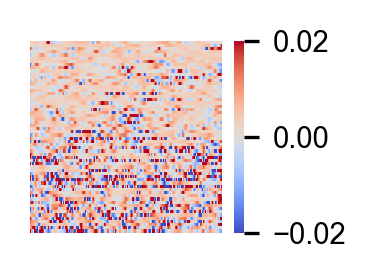

In [32]:
outputFigPath = "../jupyter_figures/" + outputPrefix + "-curvature-heatmap.svg"
plotCurvatureHeatmap(curvatureArray, outputFigPath)


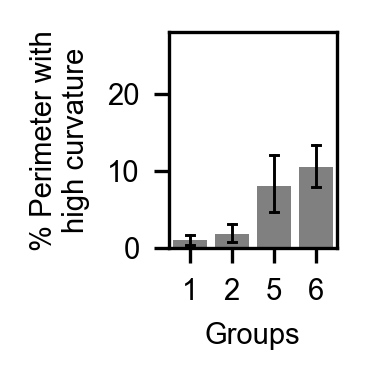

In [33]:
outputFigPath = "../jupyter_figures/" + outputPrefix + "-curvature-bar.svg"
yMax=28
yTicks=[0,10,20]
plotCurvatureBar(groups, counts, outputFigPath, yMax, yTicks)


In [34]:
df = pd.DataFrame({'groups': groups, 'data_to_compare': counts})
df.to_csv('../data_cleaned/' + outputPrefix + '-percent-high-curvature.csv')


In [35]:
# Integrin activation data set 2 (set 1 for 2 more days; 8 dpt)

# read in the data set
inputFolder = "../data/spheroids-curvature-data/20191221-8dpt-singleZ-integrin-activation-ROI-output/"
outputPrefix = "191221-8dpt-integrin-activation"
curvatureDfList = getCurvatureDfList(inputFolder, 500)

# Annotate the data set
#
# The layout of this data set is straightforward.
# For integrin activation test, only Matrigel was added (no ABA)
# Integrin activation was done by adding 50 uM MnCl2, 10 ug/mL TS2/16 or both
#
# Group 1, B2-B11: sg-Control only
# Group 2, C2-C6: sg-Control only, 50 uM MnCl2
# Group 3, C7-C11: sg-Control only, 10 ug/mL TS2/16
# Group 4, D2-D11: sg-Control only, 50 uM MnCl2 and 10 ug/mL TS2/16
# Group 5, E2-E11: sg-Control mixed with sg2-Ecad (4:1)
# Group 6, F2-F6: sg-Control mixed with sg2-Ecad (4:1), 50 uM MnCl2
# Group 7, F7-F11: sg-Control mixed with sg2-Ecad (4:1), 10 ug/mL TS2/16
# Group 8, G2-G11: sg-Control mixed with sg2-Ecad (4:1), 50 uM MnCl2 and 10 ug/mL TS2/16

groups = ["1"]*10 + ["2"]*5 + ["3"]*5 + ["4"]*10 +\
            ["5"]*10 + ["6"]*5 + ["7"]*5 + ["8"]*10

groups = ["1"]*10 + ["2"]*5 + ["1"]*5 + ["2"]*10 +\
            ["5"]*10 + ["6"]*5 + ["5"]*5 + ["6"]*10


# Read in the data set
curvatureDfList = getCurvatureDfList(inputFolder, 500)
# Get the curvature array
curvatureArray = [np.array(df.curvature) for df in curvatureDfList]
# Get the counting list of high-curvature points
# curvatureThreshold = 0.02
curvatureThreshold = np.percentile(curvatureArray, 90)
print('curvatureThreshold: ', curvatureThreshold)
counts = getHighCurvatureCounts(curvatureArray, curvatureThreshold)

# Get stats of between-group comparisons
tukeyTest(counts, groups)


curvatureThreshold:  0.00996361619271034
Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   3.9333 0.4633 -3.1517 11.0184  False
     1      5  14.5867  0.001  7.5016 21.6717   True
     1      6    15.04  0.001   7.955  22.125   True
     2      5  10.6533 0.0011  3.5683 17.7384   True
     2      6  11.1067  0.001  4.0216 18.1917   True
     5      6   0.4533    0.9 -6.6317  7.5384  False
----------------------------------------------------
p values of all pair-wise tests:
 [0.46333601 0.001      0.001      0.00111648 0.001      0.9       ]


In [36]:
df = pd.DataFrame(np.transpose(np.array([groups, counts])), columns = ["groups", "counts"])
df = df.loc[df['groups'].isin(["1", "2", "5", "6"])]

counts = np.array(df.counts.values, dtype=float)
groups = df.groups
# Get stats of between-group comparisons
tukeyTest(counts, groups)

from scipy.stats import ttest_ind
ttest_ind(counts[15:25], counts[25:35])


Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   3.9333 0.4633 -3.1517 11.0184  False
     1      5  14.5867  0.001  7.5016 21.6717   True
     1      6    15.04  0.001   7.955  22.125   True
     2      5  10.6533 0.0011  3.5683 17.7384   True
     2      6  11.1067  0.001  4.0216 18.1917   True
     5      6   0.4533    0.9 -6.6317  7.5384  False
----------------------------------------------------
p values of all pair-wise tests:
 [0.46333601 0.001      0.001      0.00111648 0.001      0.9       ]


Ttest_indResult(statistic=-2.139009297536261, pvalue=0.04639279849818144)

In [4]:
# Integrin activation data set 3

# read in the data set
inputFolder = "../data/spheroids-curvature-data/20200120-integrin-activation-MnCl2-single-z-ROI-output/"
outputPrefix = "200120-6dpt-integrin-activation"
# curvatureDfList = getCurvatureDfList(inputFolder, 500)

# Annotate the data set
#
# The layout of this data set is straightforward.
# For integrin activation test, only Matrigel was added (no ABA)
# Integrin activation was done by adding 50 uM MnCl2
#
# Group 1, B2-B11: sg-Control only
# Group 2, C2-D11: sg-Control only, 50 uM MnCl2
# Group 3, E2-E11: sg-Control mixed with sg2-Ecad (4:1)
# Group 4, F2-G11: sg-Control mixed with sg2-Ecad (4:1), 50 uM MnCl2

groups = ["1"]*10 + ["2"]*20 + ["3"]*10 + ["4"]*20

# Read in the data set
curvatureDfList = getCurvatureDfList(inputFolder, 500)
# Get the curvature array
curvatureArray = [np.array(df.curvature) for df in curvatureDfList]
# Get the counting list of high-curvature points
curvatureThreshold = 0.02
# curvatureThreshold = np.percentile(curvatureArray, 90)
# curvatureThreshold = np.percentile(np.percentile(curvatureArray, 90, axis=1), 90)
print('curvatureThreshold: ', curvatureThreshold)
counts = getHighCurvatureCounts(curvatureArray, curvatureThreshold)

# Get stats of between-group comparisons
tukeyTest(counts, groups)


2021-01-09 09:15:44,707 - INFO - NumExpr defaulting to 8 threads.
curvatureThreshold:  0.02
Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2    -1.34    0.9 -6.5261  3.8461  False
     1      3     7.02 0.0154  1.0316 13.0084   True
     1      4     6.68 0.0065  1.4939 11.8661   True
     2      3     8.36  0.001  3.1739 13.5461   True
     2      4     8.02  0.001  3.7856 12.2544   True
     3      4    -0.34    0.9 -5.5261  4.8461  False
----------------------------------------------------
p values of all pair-wise tests:
 [0.9        0.01539627 0.0064533  0.001      0.001      0.9       ]


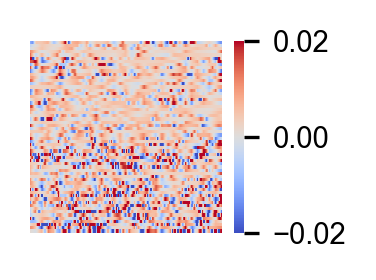

In [5]:
outputFigPath = "../jupyter_figures/" + outputPrefix + "-curvature-heatmap.svg"
plotCurvatureHeatmap(curvatureArray, outputFigPath)


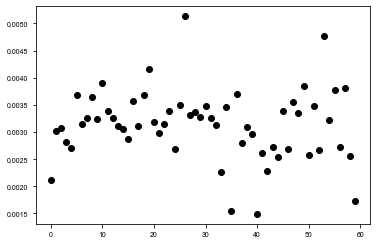

In [13]:
curvature_median = [np.median(i) for i in curvatureArray]
plt.plot(curvature_median, 'ok')

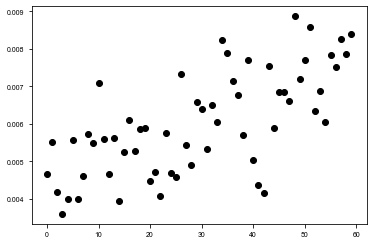

In [16]:
curvature_median = [np.percentile(i, 70) for i in curvatureArray]
plt.plot(curvature_median, 'ok')

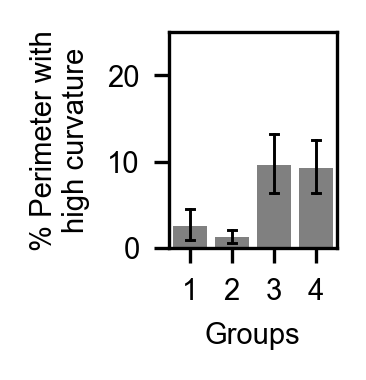

In [39]:
outputFigPath = "../jupyter_figures/" + outputPrefix + "-curvature-bar.svg"
# yMax=30
# yTicks=[0,10,20]
plotCurvatureBar(groups, counts, outputFigPath)


In [40]:
df = pd.DataFrame({'groups': groups, 'data_to_compare': counts})
df.to_csv('../data_cleaned/' + outputPrefix + '-percent-high-curvature.csv')


In [3]:
inputFolder = "../data/spheroids-curvature-data/20210125-D193-D267-mAb13-mAb16-varying-mixing-ratios-6dpt-singleZ2-ROI-output/"
outputPrefix = "210125-D193-D267-mAb13-mAb16-varying-mixing-ratios-"

# Annotate the data set
# dataset name: 20210125-D193-D267-mAb13-mAb16-varying-mixing-ratios-6dpt-singleZ2
#
#
# B2-B11: mAb13 (beta1-integrin blocking antibody) 100 μg/mL
# C2-C11: mAb16 (alpha5-integrin blocking antibody;
#         serve as isotype-matched control) 100 μg/mL
# D2-D11: sg-Control (D193) : sg1-Cdh1 (D267) = 1:1
# E2-E11: sg-Control (D193) : sg1-Cdh1 (D267) = 0:1
# F2-F11: sg-Control (D193) : sg1-Cdh1 (D267) = 4:1
# G2-G11: sg-Control (D193) : sg1-Cdh1 (D267) = 1:0

# groups = ["6"]*10 + ["5"]*10 + ["3"]*10 + ["4"]*10 + ["2"]*10 + ["1"]*10
groups = ["mAb13"]*10 + ["mAb16"]*10 + ["c"]*10 + ["d"]*10 + ["b"]*10 + ["a"]*10
# df["groups"] = groups

# Read in the data set
curvatureDfList = getCurvatureDfList(inputFolder, 500)
# Get the curvature array
curvatureArray = [np.array(df.curvature) for df in curvatureDfList]
# Get the counting list of high-curvature points
curvatureThreshold = 0.02
# curvatureThreshold = np.percentile(curvatureArray, 90)
# curvatureThreshold = np.percentile(np.percentile(curvatureArray, 90, axis=1), 90)
print('curvatureThreshold: ', curvatureThreshold)
counts = getHighCurvatureCounts(curvatureArray, curvatureThreshold)

# Get stats of between-group comparisons
tukeyTest(counts, groups)


curvatureThreshold:  0.02
Summary of test:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     a      b     4.58   0.37  -2.2668 11.4268  False
     a      c    11.68  0.001   4.8332 18.5268   True
     a      d     5.38 0.2034  -1.4668 12.2268  False
     a  mAb13     6.62 0.0637  -0.2268 13.4668  False
     a  mAb16     7.12 0.0371   0.2732 13.9668   True
     b      c      7.1 0.0379   0.2532 13.9468   True
     b      d      0.8    0.9  -6.0468  7.6468  False
     b  mAb13     2.04    0.9  -4.8068  8.8868  False
     b  mAb16     2.54 0.8728  -4.3068  9.3868  False
     c      d     -6.3 0.0879 -13.1468  0.5468  False
     c  mAb13    -5.06 0.2623 -11.9068  1.7868  False
     c  mAb16    -4.56  0.375 -11.4068  2.2868  False
     d  mAb13     1.24    0.9  -5.6068  8.0868  False
     d  mAb16     1.74    0.9  -5.1068  8.5868  False
 mAb13  mAb16      0.5    0.9  -6.3468

In [4]:
# sort one list based on another
sorted_curvatureArray = [x for _, x in sorted(zip(groups,curvatureArray), key=lambda pair: pair[0])]


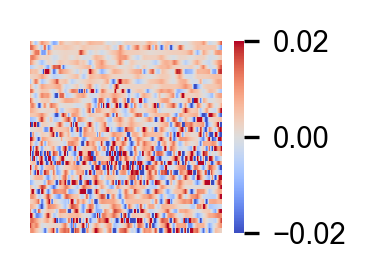

In [5]:
outputPrefix = "210125-D193-D267-varying-mixing-ratios-"
outputFigPath = "../jupyter_figures/" + outputPrefix + "-curvature-heatmap.svg"
plotCurvatureHeatmap(sorted_curvatureArray[:40], outputFigPath)


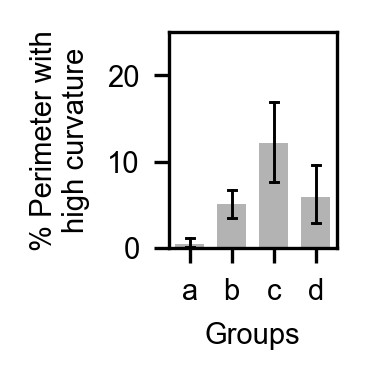

In [7]:
outputPrefix = "210125-D193-D267-varying-mixing-ratios-"
outputFigPath = "../jupyter_figures/" + outputPrefix + "-curvature-bar.svg"
# yMax=30
# yTicks=[0,10,20]
plotCurvatureBar(groups[20:], counts[20:],
                 plotting_order=['a', 'b', 'c', 'd'],
                 outputFigPath=outputFigPath)


In [8]:
inputFolder = "../data/spheroids-curvature-data/20210203-D193-D266-varying-mixing-ratios-6dpt-ROI-output/"
outputPrefix = "210203-D193-D266-varying-mixing-ratios-"

# Annotate the data set
# dataset name: 20210203-D193-D266-varying-mixing-ratios-6dpt
# new folder name: 20210203
#
# sg-Control (D193) : sg2-Cdh1 (D266; stronger guide):
# B2-B11 & C2-C6 (15 wells): 1 : 0
# C7-C11 & D2-D11 (15 wells): 4 : 1
# E2-E11 & F2-F6 (15 wells): 1 : 1
# F7-F11 & G2-G11 (15 wells): 0 : 1

# groups = ["D193"]*15 + ["25%D266"]*15 + ["50%D266"]*15 + ["D266"]*15
# groups = ["1"]*15 + ["2"]*15 + ["3"]*15 + ["4"]*15
groups = ["e"]*15 + ["f"]*15 + ["g"]*15 + ["h"]*15

# Read in the data set
curvatureDfList = getCurvatureDfList(inputFolder, 500)
# Get the curvature array
curvatureArray = [np.array(df.curvature) for df in curvatureDfList]
# Get the counting list of high-curvature points
curvatureThreshold = 0.02
# curvatureThreshold = np.percentile(curvatureArray, 90)
# curvatureThreshold = np.percentile(np.percentile(curvatureArray, 90, axis=1), 90)
print('curvatureThreshold: ', curvatureThreshold)
counts = getHighCurvatureCounts(curvatureArray, curvatureThreshold)

# Get stats of between-group comparisons
tukeyTest(counts, groups)


curvatureThreshold:  0.02
Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     e      f  13.4933  0.001  8.3816  18.605   True
     e      g  20.1067  0.001  14.995 25.2184   True
     e      h    16.36  0.001 11.2483 21.4717   True
     f      g   6.6133 0.0062  1.5016  11.725   True
     f      h   2.8667 0.4546  -2.245  7.9784  False
     g      h  -3.7467 0.2231 -8.8584   1.365  False
----------------------------------------------------
p values of all pair-wise tests:
 [0.001      0.001      0.001      0.00617368 0.45456019 0.22314976]


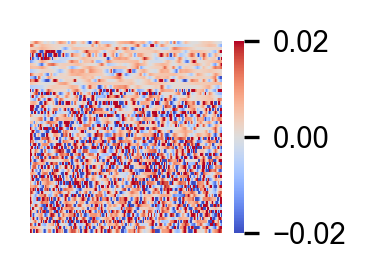

In [9]:
outputPrefix = "210203-D193-D266-varying-mixing-ratios-"
outputFigPath = "../jupyter_figures/" + outputPrefix + "-curvature-heatmap.svg"
plotCurvatureHeatmap(curvatureArray, outputFigPath)


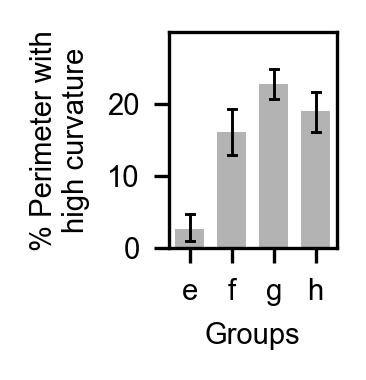

In [10]:
outputPrefix = "210203-D193-D266-varying-mixing-ratios-"
outputFigPath = "../jupyter_figures/" + outputPrefix + "-curvature-bar.svg"
# yMax=30
# yTicks=[0,10,20]
plotCurvatureBar(groups, counts,
                 outputFigPath=outputFigPath)